### README

This notebook contains 4 functions:
- `G_reg`: outputs a random regular digraph
- `G_bin`: outputs a random binomial digraph
- `SCC`: outputs (by default) the number of SCCs of an input digraph
- `sim`: calls the above 3 functions for simulations

Short information on the function arguments is given in the textbox above each function.

Following the functions are the parameters used in the paper, the simulation results and their graphs.

Note: the argument `s` in this notebook corresponds to the variable `n` in the paper (i.e. number of nodes in a digraph, or number of signers).

In [1]:
import pandas
import random
import ipyparallel as ipp
from itertools import takewhile

rc = ipp.Client()
disp = rc.load_balanced_view()


with rc[:].sync_imports():
    from networkx import DiGraph
    from numpy.random import binomial
    import random
    from math import exp, log
    import matplotlib.pyplot as mplt
    import matplotlib.lines as mlines
    from itertools import cycle


importing DiGraph from networkx on engine(s)
importing binomial from numpy.random on engine(s)
importing random on engine(s)
importing exp,log from math on engine(s)
importing matplotlib.pyplot on engine(s)
importing matplotlib.lines on engine(s)
importing cycle from itertools on engine(s)


`G_reg`: output a random regular digraph.
- k = number of incoming edges for each node (i.e. number of decoys)
- s = number of nodes (i.e. no. signers or rings)

In [2]:
def G_reg(k,s): 
    G = DiGraph()
    for i in range(s):
        G.add_edge(i,i)
    for i in range(s):
        J = random.sample(range(s-1),k)   #samples k incoming edges uniformly randomly
        for j in J:
            if j < i:
                G.add_edge(j,i)
            else:
                G.add_edge(j+1,i)
    return G

rc[:].push(dict(G_reg=G_reg))

<AsyncResult: _push>

`G_bin`: output a random binomial digraph. For i!=j, edge (i,j) exists with probability = k/(s-1).
- k = expected number of incoming edges (i.e. expected number of decoys)
- s = number of nodes (i.e. no. signers or rings)

In [3]:
def G_bin(k,s):
    G = DiGraph()
    p = k/(s-1)   #edge probability
    for i in range(s):
        G.add_edge(i,i)
    for i in range(s):
        J = binomial(1,p,size=s-1)   #sample from bernoulli(p) for each of the other s-1 nodes
        for j in range(s-1):
            if J[j]:
                if j < i:
                    G.add_edge(i,j)
                else:
                    G.add_edge(i,j+1)
    return G

rc[:].push(dict(G_bin=G_bin))

<AsyncResult: _push>

`SCC`: compute SCCs of the input directed graph G (Tarjan's algo).
source code of networkx.algorithms.components.strongly_connected.strongly_connected_components with slight modification.
- if num, return number of SCCs

In [4]:
def SCC(G, num = True):   #if num, return number of SCCs
    preorder={}
    lowlink={}
    scc_found={}
    scc_queue = []
    scc_all = []
    i=0     # Preorder counter
    for source in G:
        if source not in scc_found:
            queue=[source]
            while queue:
                v=queue[-1]
                if v not in preorder:
                    i=i+1
                    preorder[v]=i
                done=1
                v_nbrs=G[v]
                for w in v_nbrs:
                    if w not in preorder:
                        queue.append(w)
                        done=0
                        break
                if done==1:
                    lowlink[v]=preorder[v]
                    for w in v_nbrs:
                        if w not in scc_found:
                            if preorder[w]>preorder[v]:
                                lowlink[v]=min([lowlink[v],lowlink[w]])
                            else:
                                lowlink[v]=min([lowlink[v],preorder[w]])
                    queue.pop()
                    if lowlink[v]==preorder[v]:
                        scc_found[v]=True
                        scc=[v]
                        while scc_queue and preorder[scc_queue[-1]]>preorder[v]:
                            k=scc_queue.pop()
                            scc_found[k]=True
                            scc.append(k)
                        scc_all.append(scc)
                    else:
                        scc_queue.append(v)
    if num:
        return len(scc_all)
    return scc_all

rc[:].push(dict(SCC=SCC))

<AsyncResult: _push>

`sim`: simulate probability
- s = no. of nodes/ graph size (i.e. no. signers or rings) 
- N = no. simulations per estimate 
- krange = range of (expected) number of decoys 
- print_progress: if True, progress bar will be printed
- reg: if True, simulate probability for random regular digraph; if False, simulate for random binomial digraph

In [5]:
def sim(s, N, krange, print_progress = True, reg=False):   
    if s<1 or min(krange)<0:
        print("Invalid parameters.")
        return
    
    def _simstep(krange, s):
        cnt = [0 for i in range(len(krange))]
        for i in range(len(krange)):
            if krange[i] >= s:
                break
                
            if reg:
                G = G_reg(krange[i],s)
            else:
                G = G_bin(krange[i],s)
            if SCC(G)>1:   #more than 1 scc <=> not strongly connected
                cnt[i] += 1   #count number of sims where G is not strongly connected
        return cnt
    
    rc[:].push(dict(_simstep=_simstep))
    
    futures = list()
    for n in range(N):
        futures.append(disp.apply(_simstep, krange, s))
        
    cnt = [0 for i in range(len(krange))]
    for fut in futures:
        fcnt = fut.get()
        
        for i in range(len(krange)):
            cnt[i] += fcnt[i]
        
    return [cnt[i]/N for i in range(len(krange))]


# Simulation

In [6]:
results_regular = None
results_binom = None

In [7]:
#%% base case parameters
s = 1000
srange = [2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13]
N = 8000
kcap = 17
krange = range(0,min(s,kcap))


# Change to False if you want to have it quick and use old numbers
if True:

    #%% example sims
    results_regular = dict()
    for s in srange:
        results_regular[s] = dict(zip(krange, sim(s,N,krange,False,reg=True)))
    
    results_binom = dict()
    for s in srange:
        results_binom[s] = dict(zip(krange, sim(s,N,krange,False,reg=False)))

#results_binom, results_regular

In [8]:
import pickle

if results_regular is not None:
    with open('regular.pck', 'wb') as f:
        pickle.dump(results_regular, f)
else:
    with open('regular.pck', 'rb') as f:
        results_regular = pickle.load(f)
        
if results_binom is not None:
    with open('binom.pck', 'wb') as f:
        pickle.dump(results_binom, f)
else:
    with open('binom.pck', 'rb') as f:
        results_binom = pickle.load(f)

In [9]:
results_binom

{4: {0: 1.0,
  1: 0.897,
  2: 0.257125,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0},
 8: {0: 1.0,
  1: 0.996,
  2: 0.767125,
  3: 0.27025,
  4: 0.040125,
  5: 0.0015,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0},
 16: {0: 1.0,
  1: 1.0,
  2: 0.971875,
  3: 0.66525,
  4: 0.263625,
  5: 0.07075,
  6: 0.016375,
  7: 0.002,
  8: 0.000375,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0},
 32: {0: 1.0,
  1: 1.0,
  2: 0.99925,
  3: 0.928125,
  4: 0.5815,
  5: 0.2405,
  6: 0.075375,
  7: 0.021875,
  8: 0.00475,
  9: 0.002125,
  10: 0.000875,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0},
 64: {0: 1.0,
  1: 1.0,
  2: 1.0,
  3: 0.99725,
  4: 0.865875,
  5: 0.495875,
  6: 0.1995,
  7: 0.07525,
  8: 0.02475,
  9: 0.01,
  10: 0.002,
  11: 0.000875,
  12: 0.000375,
  13

[<AxesSubplot:xlabel='k', ylabel='Probability'>,
 <AxesSubplot:xlabel='k', ylabel='Probability'>]

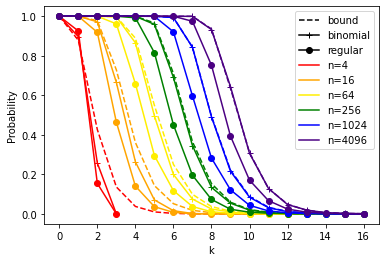

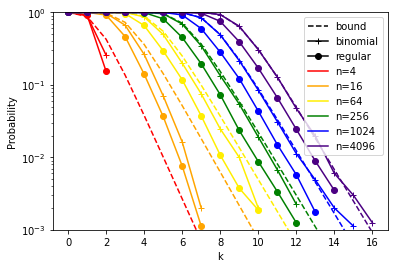

In [10]:


fig1, ax1 = mplt.subplots(figsize=(6, 4))
fig2, ax2 = mplt.subplots(figsize=(6, 4))

#ax1.set_ylim([0,1])
ax2.set_yscale('log')
ax2.set_ylim([10**(-3),1])


legs = list()

legs.append(mlines.Line2D([], [], color='black', linestyle='--', label='bound'))
legs.append(mlines.Line2D([], [], color='black', marker='+', label='binomial'))
legs.append(mlines.Line2D([], [], color='black', marker='o', label='regular'))

for plt in [ax1, ax2]:
    plt.set_xlabel('k')
    plt.set_ylabel('Probability')
    colors = cycle(['Red','Orange','#ffee00','Green','Blue', 'Indigo', 'Violet'])
    for s in srange[::2]:
        color = next(colors)
            
        if plt is ax1:
            legs.append(mlines.Line2D([], [], color=color, label=f'n={s}'))
        
        yreg = results_regular[s].values()
        ybin = results_binom[s].values()
        if s == 4:
            yreg = list(yreg)[:4]
            ybin = list(ybin)[:4]
        if plt is ax2:
            yreg = list(takewhile(lambda x: x > 10**(-3), yreg))
            ybin = list(takewhile(lambda x: x > 10**(-3), ybin))
            
        plt.plot([k for k in krange[:len(ybin)]], ybin, marker = '+', color = color, label=f's={s} binomial')
        plt.plot([k for k in krange[:len(yreg)]], yreg, marker = 'o', color = color, label=f's={s} regular')
        plt.plot([k for k in krange], [1-exp(-2*exp(log(s)-s*i/(s-1))) for i in krange], color = color, linestyle="--")  #limit


ax1.legend(loc='upper right', handles=legs)
ax2.legend(loc='upper right', handles=legs)
fig1.savefig('plot-for-k.pdf', pad_inches=0, bbox_inches='tight')
fig2.savefig('plot-for-k-log.pdf', pad_inches=0, bbox_inches='tight')

[ax1, ax2]

[<AxesSubplot:xlabel='n', ylabel='Probability'>,
 <AxesSubplot:xlabel='n', ylabel='Probability'>]

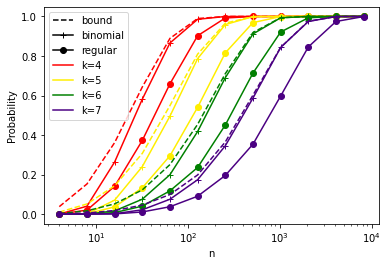

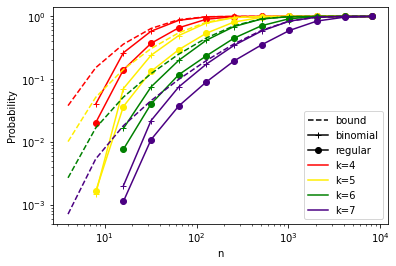

In [11]:
fig1, ax1 = mplt.subplots(figsize=(6, 4))
fig2, ax2 = mplt.subplots(figsize=(6, 4))

ax2.set_yscale('log')
ax1.set_xscale('log')
ax2.set_xscale('log')

legs = list()

legs.append(mlines.Line2D([], [], color='black', linestyle='--', label='bound'))
legs.append(mlines.Line2D([], [], color='black', marker='+', label='binomial'))
legs.append(mlines.Line2D([], [], color='black', marker='o', label='regular'))


for plt in [ax1, ax2]:
    colors = cycle(['Red','#FFee00','Green','Indigo'])
    therange = [4,5,6,7]#list(range(4, max(krange), 4))[:5]
    for k in therange:
        color = next(colors)
        
        ybin = [ results_binom[s][k] for s in srange ]
        yreg = [ results_regular[s][k] for s in srange ]
        if plt is ax2:
            yreg = list(reversed(list(takewhile(lambda x: x > 10**(-3), reversed(yreg)))))
            ybin = list(reversed(list(takewhile(lambda x: x > 10**(-3), reversed(ybin)))))
        
        if plt is ax1:
            legs.append(mlines.Line2D([], [], color=color, label=f'k={k}'))
        plt.plot(srange[len(srange)-len(ybin):], ybin,   marker = '+', color = color, label=f'k={k} binomial')
        plt.plot(srange[len(srange)-len(yreg):], yreg, marker = 'o', color = color, label=f'k={k} regular')
        plt.plot(srange, [1-exp(-2*exp(log(i)-i*k/(i-1))) for i in srange], color = color, linestyle="--")  #limit

        

ax1.legend(loc='upper left', handles=legs)
ax1.set_xlabel('n')
ax1.set_ylabel('Probability')

ax2.legend(loc='lower right', handles=legs)
ax2.set_xlabel('n')
ax2.set_ylabel('Probability')

fig1.savefig('plot-for-s.pdf', pad_inches=0, bbox_inches='tight')
fig2.savefig('plot-for-s-log.pdf', pad_inches=0, bbox_inches='tight')
        

[ax1, ax2]